## Import Libs

In [1]:
import os,sys
# install deepspeech - https://github.com/SeanNaren/deepspeech.pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import hydra


from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
from deepspeech_pytorch.utils import load_model, load_decoder
from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline


In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(161,1024)
        self.fc2 = nn.Linear(1024, 29)
        self.seq = SequenceWise(nn.Sequential(self.fc1, nn.ReLU(), self.fc2))
    def forward(self,x):
        #torch.Size([1, 1, 161, 20])
        n,c,h,t = x.shape
        x = x.permute(3,0,1,2) # tnch
        x = x.reshape(t,n, c*h)
        x = self.seq(x) # t,n,-1
        x = x.permute(1,0,2) # n,-1,t

        return x
model_simple = SimpleModel().cuda()

In [43]:
cfg

EvalConfig(lm=LMConfig(decoder_type=<DecoderType.greedy: 'greedy'>, lm_path='', top_paths=1, alpha=0.0, beta=0.0, cutoff_top_n=40, cutoff_prob=1.0, beam_width=10, lm_workers=4), model=ModelConfig(precision=32, cuda=True, model_path=''), test_path='', verbose=True, save_output='', batch_size=1, num_workers=4)

NameError: name 'model_ds' is not defined

In [5]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()

# set bs = 1, device
cfg.batch_size=1
device = torch.device("cuda" if cfg.model.cuda else "cpu")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=model_ds.spect_cfg,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------


inputs, targets, input_percentages, target_sizes = next(iter(test_loader)) 
inputs = inputs.to(device)
targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

inputs = inputs[:,:,:,-60:-40] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print('input shape:',inputs.shape)


input shape: torch.Size([1, 1, 161, 20])


In [6]:
model_ds.labels

['_',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 ' ']

In [30]:
cfg

EvalConfig(lm=LMConfig(decoder_type=<DecoderType.greedy: 'greedy'>, lm_path='', top_paths=1, alpha=0.0, beta=0.0, cutoff_top_n=40, cutoff_prob=1.0, beam_width=10, lm_workers=4), model=ModelConfig(precision=32, cuda=True, model_path=''), test_path='', verbose=True, save_output='', batch_size=1, num_workers=4)

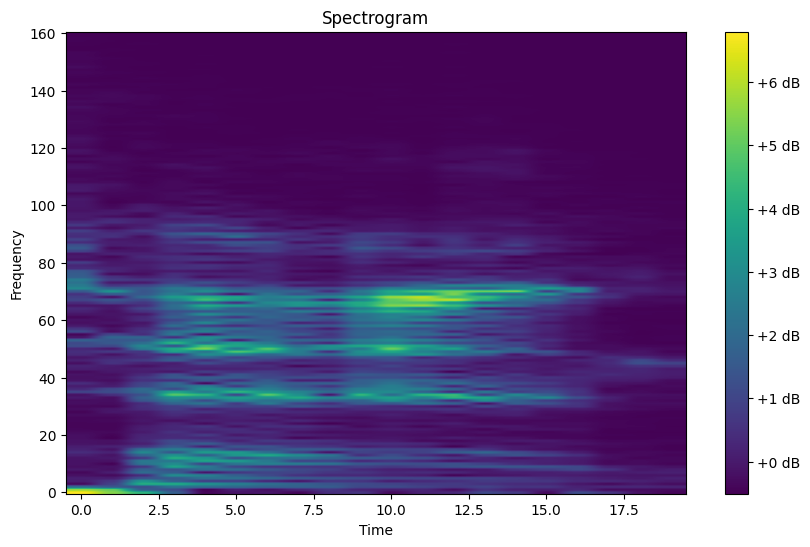

In [31]:
plot_spectrogram(inputs.detach())

In [32]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
# weight_param = model_ds.fc[0].module[1].weight
weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out  = model_simple(inputs) # 1 176 29

# make target same size of output size
targets = targets[-10:]
target_sizes[0]= len(targets)

# make output size for simple model
output_sizes = torch.tensor([out.shape[1]])
hs = out

print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 1024])
model input shape, input_sizes: torch.Size([1, 1, 161, 20]) tensor([20], dtype=torch.int32)
model output shape, output_sizes, hidden sizes: torch.Size([1, 20, 29]) tensor([20]) 1
target sizes, targets:  tensor([10], dtype=torch.int32) tensor([28, 21,  9,  6, 28, 21,  6, 15, 21, 20], device='cuda:0')
loss: 4.9838858094937155
loss by pt lib: 4.983885765075684
grad shape: torch.Size([29, 1024]) grad_norm tensor(9.4123, device='cuda:0')


In [33]:
# targets = torch.tensor([1, 2,  3,  4, 5, 6,  7, 8, 9, 10], device='cuda:0')


In [34]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=True)
out = model_simple(x_hat)
out = out.transpose(0, 1)  # TxNxH

out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
print(meta_loss(out, targets, None, None, dldw_target,  weight_param)[0])

tensor(60.2624, device='cuda:0', grad_fn=<SumBackward0>)


In [35]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_hat], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)

i=0
loss_history = []
while True:

    out = model_simple(x_hat) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()

    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if (i+ 1) % 10000 == 0:
        torch.save({
            'model':model_ds.state_dict(),
            'loss_history': loss_history,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
             }, f'model_checkpoint_{i+ 1}.pt')
        print(f'Model saved at iteration {i+ 1}')


    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 60.2624, 2.1973, 0.1000


Iteration, Loss, Gradient Norm, Learning Rate:   10, 9.5156, 0.7816, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 4.2220, 0.4817, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 2.0486, 0.2578, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 1.1252, 0.1593, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 0.7034, 0.0958, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 0.5086, 0.0631, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 0.3940, 0.0434, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 0.3197, 0.0307, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 0.2695, 0.0232, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 0.2327, 0.0193, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 0.2037, 0.0162, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 0.1811, 0.0142, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  130, 0.1628, 0.0126, 0.1000
Iteration, L

KeyboardInterrupt: 

## Plot sth

In [36]:
%matplotlib inline

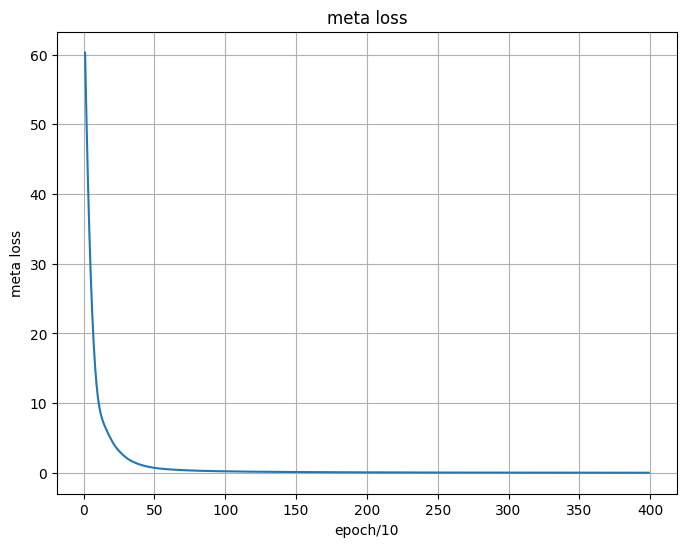

In [37]:
plot_loss_over_epoch(loss_history, 'meta loss','epoch/10','meta loss')

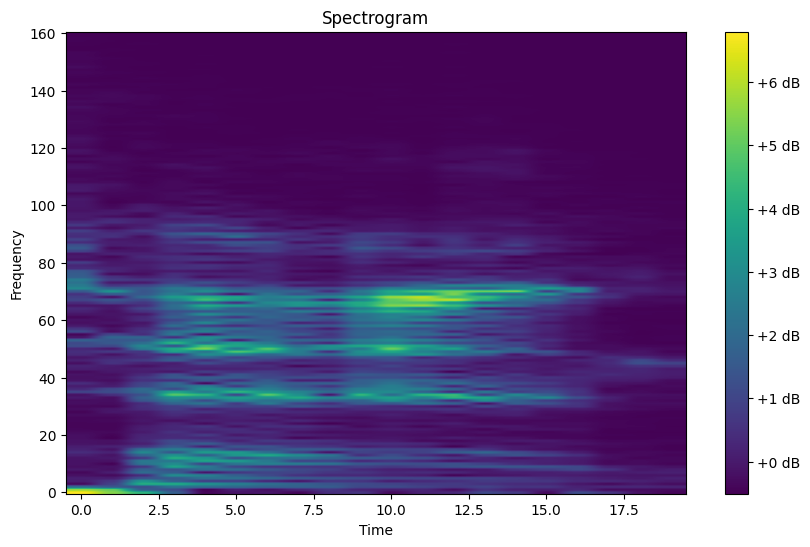

In [38]:
plot_spectrogram(inputs.detach())

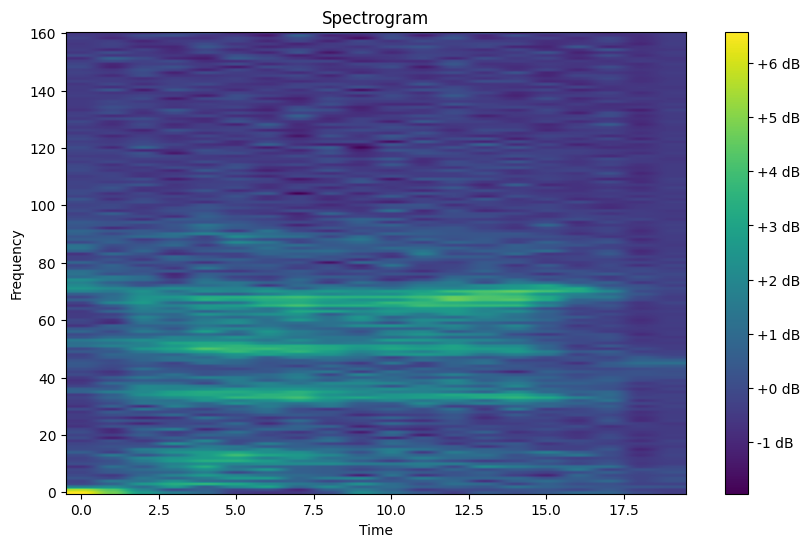

In [39]:
plot_spectrogram(x_hat.detach())

In [12]:
#pytorch 2nd order derivative test 
f = lambda x: x**3 + 2*x**2 - 3*x + 1
x = torch.tensor(1.0, requires_grad=True)

z = f(x)
y = z


dydx = torch.autograd.grad(y, x, create_graph=True)
d2ydx = torch.autograd.grad(dydx, x) # 10
print(dydx, d2ydx)

(tensor(4., grad_fn=<AddBackward0>),) (tensor(10.),)


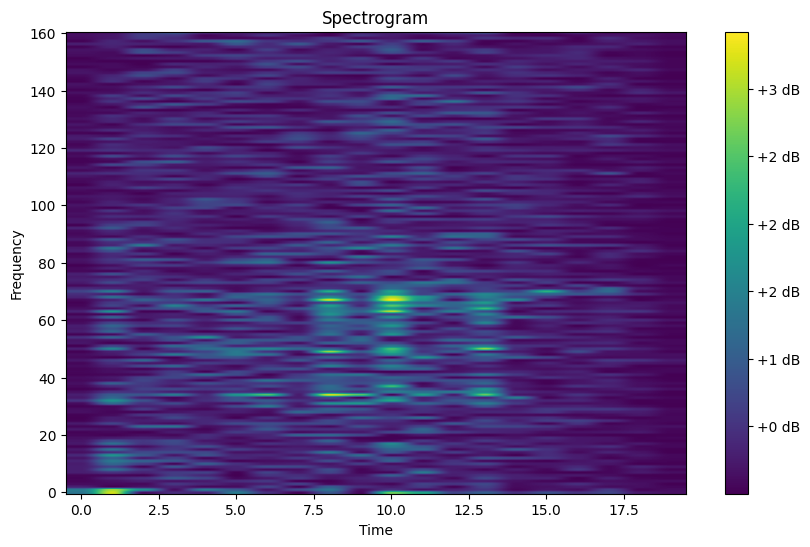

In [15]:
plot_spectrogram(torch.abs(inputs.detach() - x_hat.detach()))

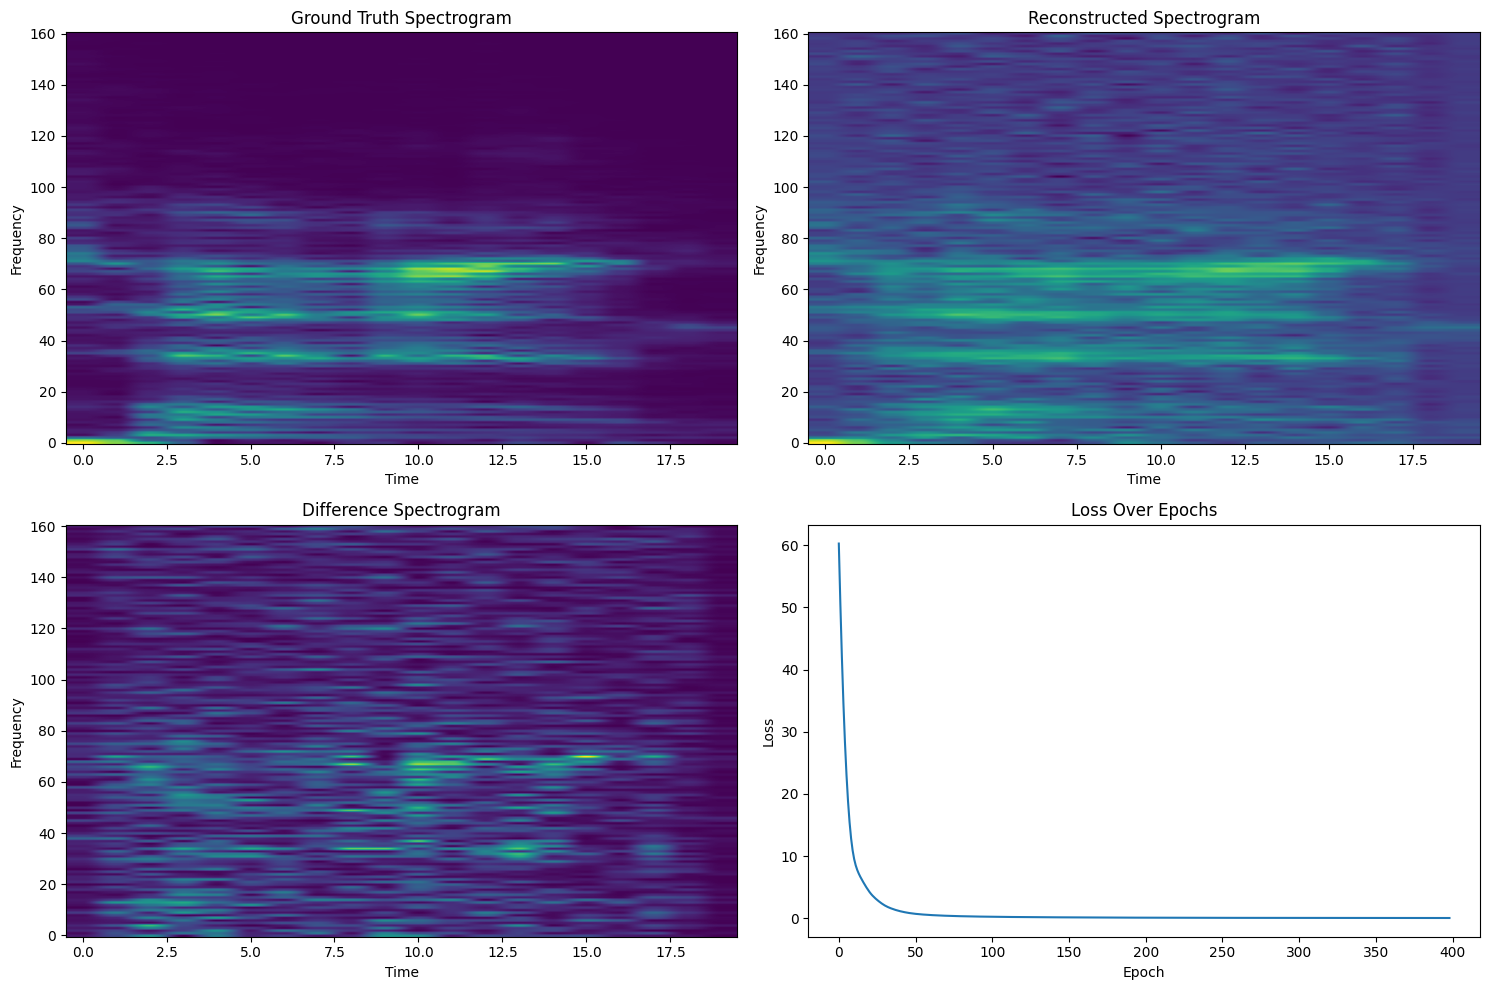

In [42]:
plot_four_graphs(inputs.detach(), x_hat.detach(), loss_history)